In [848]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline
window_size = 50

In [849]:
endpoint = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym=AVAX&tsym=USDT&limit=2000&api_key=d030e2d4b355590e02d53bffc395ed91a2de64c65fbf38825b36f45d58e5f8d9'
res = requests.get(endpoint)
ihist = pd.DataFrame(json.loads(res.content)['Data']['Data'])
ihist = ihist.set_index('time')
ihist.index = pd.to_datetime(ihist.index, unit='s')

target_col = 'high' + str(window_size - 1)
ihist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

ihist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-08-29 14:00:00,48.12,47.01,47.72,354181.38,16820935.02,47.11
2021-08-29 15:00:00,47.32,46.68,47.11,346154.91,16279196.55,47.13
2021-08-29 16:00:00,48.17,47.04,47.13,295926.69,14074652.16,48.01
2021-08-29 17:00:00,48.25,47.58,48.01,255684.12,12258506.26,47.95
2021-08-29 18:00:00,47.96,47.71,47.95,24183.13,1156672.70,47.72


In [850]:
newcols = []
for i in range(0, window_size):
  newcols.append("high" + str(i))
  newcols.append("low" + str(i))
  newcols.append("open" + str(i))
  newcols.append("close" + str(i))
  # newcols.append("volumefrom" + str(i))
  # newcols.append("volumeto" + str(i))

#print(newcols)
hist = pd.DataFrame(columns = newcols)
count = 0
current_row = []
idx = 0

allrows = []
for index, row in ihist.iterrows():
  tmp = [row['high'], row['low'], row['open'], row['close']]
  allrows.extend(tmp)
  

count = 0;
lastrow = []
for idx, val in enumerate(allrows):
  if (idx + 4*window_size <= len(allrows)) and idx%4==0:
    lastrow = allrows[idx:idx + (4 * window_size)]
    hist.loc[count] = lastrow.copy()
    count = count+1
    # print(lastrow)
    # break;

# print(len(hist))
# print((1999 - window_size - 1))

lastr = lastrow.copy()
lastr = lastr[4:]
lastr.extend([lastrow[len(lastrow) -4], 0, 0, 0])

hist.loc[count] = lastr
hist.drop(["close" + str(window_size-1), "low" + str(window_size-1), "open" + str(window_size-1)], axis = 'columns', inplace = True)
hist.tail(5)

,high0,low0,open0,close0,high1,low1,open1,close1,high2,low2,open2,close2,high3,low3,open3,close3,high4,low4,open4,close4,high5,low5,open5,close5,high6,low6,open6,close6,high7,low7,open7,close7,high8,low8,open8,close8,high9,low9,open9,close9,...,low39,open39,close39,high40,low40,open40,close40,high41,low41,open41,close41,high42,low42,open42,close42,high43,low43,open43,close43,high44,low44,open44,close44,high45,low45,open45,close45,high46,low46,open46,close46,high47,low47,open47,close47,high48,low48,open48,close48,high49
1948,47.42,44.62,44.80,46.59,47.87,46.21,46.59,46.87,47.55,46.01,46.87,47.45,49.35,47.38,47.45,47.89,48.83,47.51,47.89,48.81,48.94,47.81,48.81,48.11,48.92,47.15,48.11,48.71,50.43,48.55,48.71,49.74,50.39,49.19,49.74,50.12,50.30,49.35,50.12,50.12,...,48.17,49.28,49.32,49.44,48.39,49.32,49.12,49.33,48.51,49.12,48.68,49.18,48.19,48.68,48.74,48.79,47.56,48.74,48.69,49.23,48.44,48.69,48.55,48.71,47.57,48.55,47.68,48.37,47.49,47.68,47.81,48.22,47.65,47.81,47.72,48.12,47.01,47.72,47.11,47.32
1949,47.87,46.21,46.59,46.87,47.55,46.01,46.87,47.45,49.35,47.38,47.45,47.89,48.83,47.51,47.89,48.81,48.94,47.81,48.81,48.11,48.92,47.15,48.11,48.71,50.43,48.55,48.71,49.74,50.39,49.19,49.74,50.12,50.30,49.35,50.12,50.12,50.63,48.11,50.12,48.50,...,48.39,49.32,49.12,49.33,48.51,49.12,48.68,49.18,48.19,48.68,48.74,48.79,47.56,48.74,48.69,49.23,48.44,48.69,48.55,48.71,47.57,48.55,47.68,48.37,47.49,47.68,47.81,48.22,47.65,47.81,47.72,48.12,47.01,47.72,47.11,47.32,46.68,47.11,47.13,48.17
1950,47.55,46.01,46.87,47.45,49.35,47.38,47.45,47.89,48.83,47.51,47.89,48.81,48.94,47.81,48.81,48.11,48.92,47.15,48.11,48.71,50.43,48.55,48.71,49.74,50.39,49.19,49.74,50.12,50.30,49.35,50.12,50.12,50.63,48.11,50.12,48.50,48.60,47.74,48.50,48.30,...,48.51,49.12,48.68,49.18,48.19,48.68,48.74,48.79,47.56,48.74,48.69,49.23,48.44,48.69,48.55,48.71,47.57,48.55,47.68,48.37,47.49,47.68,47.81,48.22,47.65,47.81,47.72,48.12,47.01,47.72,47.11,47.32,46.68,47.11,47.13,48.17,47.04,47.13,48.01,48.25
1951,49.35,47.38,47.45,47.89,48.83,47.51,47.89,48.81,48.94,47.81,48.81,48.11,48.92,47.15,48.11,48.71,50.43,48.55,48.71,49.74,50.39,49.19,49.74,50.12,50.30,49.35,50.12,50.12,50.63,48.11,50.12,48.50,48.60,47.74,48.50,48.30,48.57,47.18,48.30,47.55,...,48.19,48.68,48.74,48.79,47.56,48.74,48.69,49.23,48.44,48.69,48.55,48.71,47.57,48.55,47.68,48.37,47.49,47.68,47.81,48.22,47.65,47.81,47.72,48.12,47.01,47.72,47.11,47.32,46.68,47.11,47.13,48.17,47.04,47.13,48.01,48.25,47.58,48.01,47.95,47.96
1952,48.83,47.51,47.89,48.81,48.94,47.81,48.81,48.11,48.92,47.15,48.11,48.71,50.43,48.55,48.71,49.74,50.39,49.19,49.74,50.12,50.30,49.35,50.12,50.12,50.63,48.11,50.12,48.50,48.60,47.74,48.50,48.30,48.57,47.18,48.30,47.55,48.54,46.60,47.55,46.89,...,47.56,48.74,48.69,49.23,48.44,48.69,48.55,48.71,47.57,48.55,47.68,48.37,47.49,47.68,47.81,48.22,47.65,47.81,47.72,48.12,47.01,47.72,47.11,47.32,46.68,47.11,47.13,48.17,47.04,47.13,48.01,48.25,47.58,48.01,47.95,47.96,47.71,47.95,47.72,47.96


In [851]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [852]:
train, test = train_test_split(hist, test_size=0.2)

In [853]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

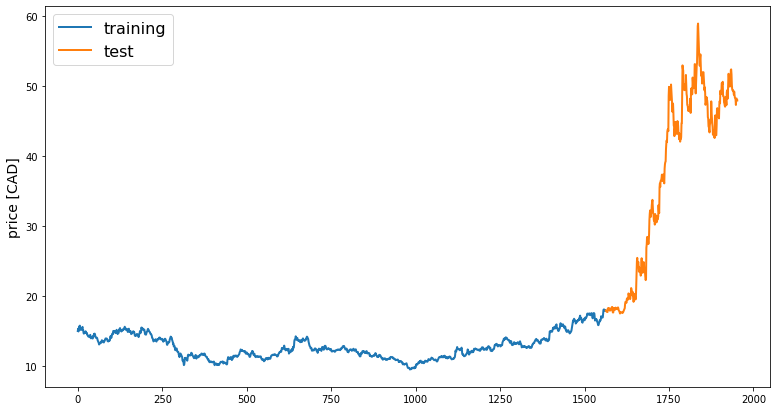

In [854]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [855]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [856]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [857]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [858]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [859]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [860]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [861]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
49/49 [==============================] - 3s 19ms/step - loss: 6.4225e-04 - val_loss: 0.0021
Epoch 2/20
49/49 [==============================] - 0s 9ms/step - loss: 3.9105e-04 - val_loss: 0.0018
Epoch 3/20
49/49 [==============================] - 0s 9ms/step - loss: 2.9650e-04 - val_loss: 0.0017
Epoch 4/20
49/49 [==============================] - 0s 9ms/step - loss: 2.8653e-04 - val_loss: 0.0015
Epoch 5/20
49/49 [==============================] - 0s 9ms/step - loss: 2.5581e-04 - val_loss: 0.0013
Epoch 6/20
49/49 [==============================] - 0s 9ms/step - loss: 2.2616e-04 - val_loss: 0.0013
Epoch 7/20
49/49 [==============================] - 0s 9ms/step - loss: 2.1704e-04 - val_loss: 0.0013
Epoch 8/20
49/49 [==============================] - 0s 9ms/step - loss: 2.0399e-04 - val_loss: 0.0012
Epoch 9/20
49/49 [==============================] - 0s 9ms/step - loss: 2.0024e-04 - val_loss: 0.0012
Epoch 10/20
49/49 [==============================] - 0s 9ms/step - loss: 1.8660e-

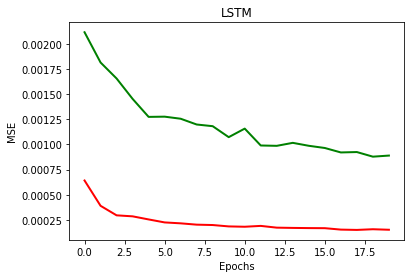

In [862]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [863]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.020313624793253077

In [864]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.000889518934059766

In [865]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7717376708048361

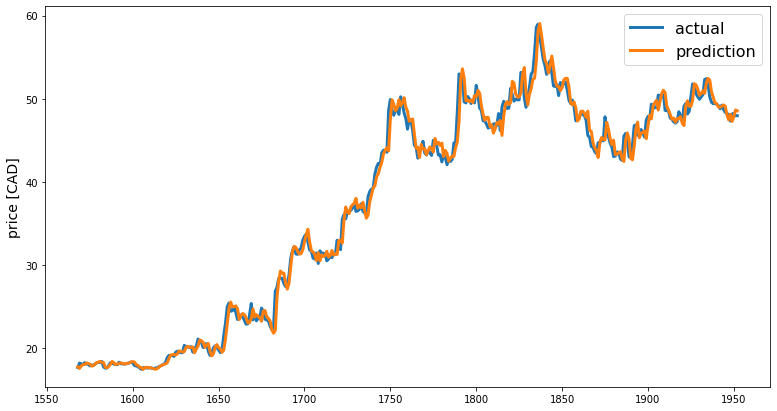

In [866]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [867]:
print(preds.tail(5))
print(targets.tail(5))

1948    48.135795
1949    47.273763
1950    47.869778
1951    48.646303
1952    48.549584
dtype: float64
1948    47.32
1949    48.17
1950    48.25
1951    47.96
1952    47.96
Name: high49, dtype: float64


443    49.23
444    48.71
445    48.37
446    48.22
447    48.12
448    47.32
449    48.17
450    48.25
451    47.96
452    47.96
Name: high49, dtype: float64
443    49.088084
444    49.253641
445    49.124832
446    48.070877
447    47.451911
448    48.135795
449    47.273763
450    47.869778
451    48.646303
452    48.549584
dtype: float64


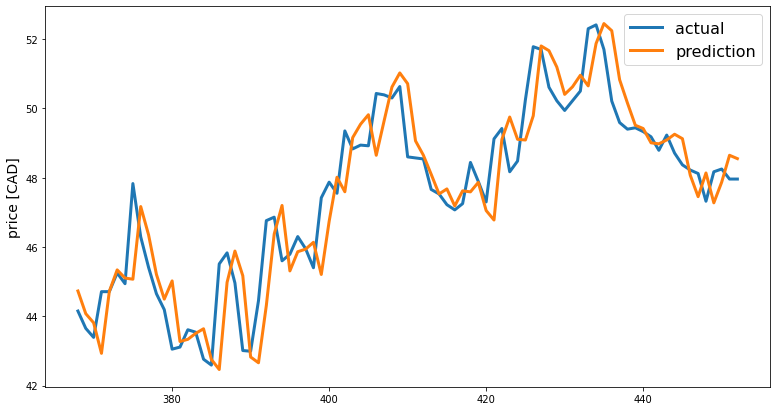

In [868]:
endpoint = 'https://min-api.cryptocompare.com/data/v2/histohour?fsym=AVAX&tsym=USDT&limit=500&api_key=d030e2d4b355590e02d53bffc395ed91a2de64c65fbf38825b36f45d58e5f8d9'

res = requests.get(endpoint)
ihist = pd.DataFrame(json.loads(res.content)['Data']['Data'])
ihist = ihist.set_index('time')
ihist.index = pd.to_datetime(ihist.index, unit='s')

target_col = 'high' + str(window_size - 1)
ihist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

newcols = []
for i in range(0, window_size):
  newcols.append("high" + str(i))
  newcols.append("low" + str(i))
  newcols.append("open" + str(i))
  newcols.append("close" + str(i))
  # newcols.append("volumefrom" + str(i))
  # newcols.append("volumeto" + str(i))

#print(newcols)
hist = pd.DataFrame(columns = newcols)
count = 0
current_row = []
idx = 0

allrows = []
for index, row in ihist.iterrows():
  tmp = [row['high'], row['low'], row['open'], row['close']]
  allrows.extend(tmp)
  

count = 0;
lastrow = []
for idx, val in enumerate(allrows):
  if (idx + 4*window_size <= len(allrows)) and idx%4==0:
    lastrow = allrows[idx:idx + (4 * window_size)]
    hist.loc[count] = lastrow.copy()
    count = count+1
    # print(lastrow)
    # break;

# print(len(hist))
# print((1999 - window_size - 1))

lastr = lastrow.copy()
lastr = lastr[4:]
lastr.extend([lastrow[len(lastrow) -4], 0, 0, 0])

hist.loc[count] = lastr
hist.drop(["close" + str(window_size-1), "low" + str(window_size-1), "open" + str(window_size-1)], axis = 'columns', inplace = True)

#Test
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)
print(targets.tail(10))
print(preds.tail(10))


In [394]:
preds.tail(5)

381    73.946401
382    73.883370
383    73.993585
384    73.959212
385    74.004745
dtype: float64